In [1]:
pip install torchsort

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for torchsort: filename=torchsort-0.1.9-cp311-cp311-linux_x86_64.whl size=3192827 sha256=40343d73aaf1133d4e022cfa8919e858940ee3b6e36df3a3165717cf33b9dc3d
  Stored in directory: /root/.cache/pip/wheels/93/6c/7f/e6c32a7bc4da2f9ad262232c970d09b65a71d3a3741ded35e7
Successfully built torchsort
  Attempting 

In [2]:
!apt-get update -qq
!apt-get install -y libatlas-base-dev liblapack-dev libblas-dev libffi-dev
!pip install git+https://github.com/getspams/spams-python.git
!pip install staintools

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libffi-dev is already the newest version (3.4.2-4).
libffi-dev set to manually installed.
liblapack-dev is already the newest version (3.10.0-2ubuntu1).
libatlas-base-dev is already the newest version (3.10.3-12ubuntu1).
Suggested packages:
  liblapack-doc
The following NEW packages will be installed:
  libblas-dev
0 upgraded, 1 newly installed, 0 to remove and 157 not upgraded.
Need to get 164 kB of archives.
After this operation, 1,084 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libblas-dev amd64 3.10.0-2ubuntu1 [164 kB]
Fetched 164 kB in 2s (108 kB/s)       
Selecting previously unselected package libblas-dev:amd64.
(Reading database ... 129184 file

In [3]:
import h5py
import numpy as np
from staintools import StainNormalizer
import staintools

# Load reference image (float32, 0-1)
with h5py.File('/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5', 'r') as f:
    ref_image = f['images/Train/S_1'][()]

# Convert to uint8 (0-255)
ref_image_uint8 = (ref_image * 255).clip(0, 255).astype(np.uint8)

# Initialize and fit normalizer
normalizer = StainNormalizer(method='vahadane')
normalizer.fit(ref_image_uint8) 


norm_images={}
wihout_norm=[]
# Process all slides
for slide_id in ['S_1', 'S_2', 'S_3','S_4','S_5','S_6', 'S_7']:
    # Load slide (adjust path for train/test)
    with h5py.File('/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5', 'r') as f:
    
        slide = f[f'images/Train/{slide_id}'][()] if slide_id != 'S_7' else f[f'images/Test/S_7'][()]
        
    slide = (slide * 255).clip(0, 255).astype(np.uint8)
    wihout_norm.append(slide)
    
    # Normalize entire slide
    slide = staintools.LuminosityStandardizer.standardize(slide)
    slide_normalized = normalizer.transform(slide)

    norm_images[slide_id]= slide_normalized

In [4]:
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms,models
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from transformers import AutoImageProcessor, AutoModel


# Configuration
CFG = {
    "seed": 48,
    "img_size": 400,
    "batch_size": 32,
    "num_workers": 4,
    "num_epochs": 20,
    "lr": 1e-4,
    "weight_decay": 1e-5,
    "train_ratio": 0.9,
    "num_cell_types": 35,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
}

# Set random seeds
torch.manual_seed(CFG['seed'])
np.random.seed(CFG['seed'])

# Custom Dataset
class HistologyDataset(Dataset):
    def __init__(self, h5_path, slides,images,transform_fn=None, train=True):
        self.h5 = h5py.File(h5_path, 'r')
        self.transform_fn = transform_fn
        self.train_spots = []
        self.val_spots = []
        self.slide_metadata = {}
        self.images=images
        self.train=train
        # Load data based on train/test split
        group = 'Train' if train else 'Test'
        #slides = list(self.h5[f'{group}/Images'].keys())
        self.slides = slides
        
        for slide_id in self.slides:
            img = self.h5[f'images/Train/{slide_id}']
            spots = self.h5[f'spots/Train/{slide_id}']
            
            # Store slide dimensions
            self.slide_metadata[slide_id] = {
                'height': img.shape[0],
                'width': img.shape[1]
            }
            
            for spot in spots:

                #skip=1
                x0, y0 = spot['x'], spot['y']
                # Access the 'abundances' field instead of slicing
                cell_cols = [f'C{i}' for i in range(1,36)]

                abundances = torch.FloatTensor(spot[cell_cols])
                
                
                abundances=torch.log(abundances)
                
                
                if slide_id=='S_1' and x0>500 and x0<100 and y0>1000 and y0<1500:
                 # abundances=np.array(abundances)
                    self.val_spots.append((
                        slide_id,
                        x0, y0,
                        abundances
                    ))
                elif slide_id=='S_2' and x0>1000 and x0<1500 and y0>0 and y0<800:
                    self.val_spots.append((
                        slide_id,
                        x0, y0,
                        abundances
                    ))
                elif slide_id=='S_3' and x0>1000 and x0<1500 and y0>1000 and y0<1300:
                    self.val_spots.append((
                        slide_id,
                        x0, y0,
                        abundances
                    ))
                elif slide_id=='S_4' and x0>1000 and x0<1500 and y0>1000 and y0<1300:
                    self.val_spots.append((
                        slide_id,
                        x0, y0,
                        abundances
                    ))

                elif slide_id=='S_5' and x0>0 and x0<1000 and y0>0 and y0<800:
                    self.val_spots.append((
                        slide_id,
                        x0, y0,
                        abundances
                    ))
                else:
                    self.train_spots.append((
                                        slide_id,
                                        x0, y0,
                                        abundances
                                    ))

    

    def __len__(self):
        if self.train:
            
            return len(self.train_spots)
        else:
            
            return len(self.val_spots)

    def __getitem__(self, idx):
        if self.train:
            slide_id, x, y, abundances = self.train_spots[idx]
            #img = self.h5[f'images/Train/{slide_id}']
        else:
            slide_id, x, y, abundances = self.val_spots[idx]
            
      
            
        img = self.images[slide_id]
        meta = self.slide_metadata[slide_id]
        
        # Extract patch with reflection padding
        half = CFG['img_size'] // 2
        y_min = max(0, y - half)
        y_max = min(img.shape[0], y + half)
        x_min = max(0, x - half)
        x_max = min(img.shape[1], x + half)
        
        patch = img[y_min:y_max, x_min:x_max]
        
        # Apply padding if needed
        pad_top = half - (y - y_min)
        pad_bottom = (y + half) - y_max
        pad_left = half - (x - x_min)
        pad_right = (x + half) - x_max
        
        patch = np.pad(patch,
                      ((pad_top, pad_bottom),
                       (pad_left, pad_right),
                       (0, 0)),
                      mode='reflect')
        
        # Normalize coordinates
        norm_x = x / meta['width']
        norm_y = y / meta['height']
        
        if self.transform_fn:
            patch = self.transform_fn(patch)
            
        return [patch,  # Ensure image patch is float32
        torch.tensor([norm_x, norm_y], dtype=torch.float32),  # Explicit float32
        abundances]  # Ensure targets are float32
    


2025-05-27 18:55:39.560377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748372139.739392      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748372139.792429      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([400]),
    transforms.RandomResizedCrop([400],scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([400]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_slides=['S_1','S_2','S_3','S_4','S_5','S_6']
val_slides=['S_1','S_2','S_3','S_4','S_5']
      
# Create datasets and dataloaders
train_dataset = HistologyDataset(
    "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5",
    train_slides,
    norm_images,
    transform_fn=train_transform,
    train=True
)

val_dataset = HistologyDataset(
    "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5",
    val_slides,
    norm_images,
    transform_fn=val_transform,
    train=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=CFG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=CFG['num_workers'],
    pin_memory=True
)

print(len(train_dataset))
print(len(val_dataset))

7520
829


In [7]:
import torchsort

def spearman_loss(pred, target):
    pred_ranks = torchsort.soft_rank(pred, regularization_strength=0.1)
    target_ranks = torchsort.soft_rank(target, regularization_strength=0.1)
    
    # Reshape to treat entire batch as a single vector
    pred_centered = pred_ranks.flatten() - pred_ranks.flatten().mean()
    target_centered = target_ranks.flatten() - target_ranks.flatten().mean()
    
    covariance = (pred_centered * target_centered).sum()
    pred_std = torch.sqrt((pred_centered ** 2).sum())
    target_std = torch.sqrt((target_centered ** 2).sum())
    correlation = covariance / (pred_std * target_std + 1e-8)
    return 1.0 - correlation

def combined_loss(pred, target,alpha=0.85):
    mse = nn.MSELoss()(pred, target)
    spr = spearman_loss(pred, target)
    return alpha * spr + (1 - alpha) * mse

In [ ]:
class SpatialCellModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load backbone
        self.backbone = models.convnext_small(weights="DEFAULT")
        # Remove the final classification layer
        self.backbone.classifier = nn.Identity()

        for param in self.backbone.features.parameters():
            param.requires_grad = False
        
        for param in self.backbone.features[-2:].parameters(): 
            param.requires_grad = True
            
        # Adjusted head for 1280 input features
        self.fc1=nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                  
            nn.Linear(768, 1024),
            nn.ReLU(),                     
            nn.BatchNorm1d(1024)
        )
        
    
        self.coord_encoder = nn.Sequential(
                nn.Linear(2, 256),
                nn.GELU(),
                nn.Dropout(0.3),
            
                nn.Linear(256, 1024)  # Match image feature dimension
            )
        

        self.head = nn.Sequential(
            

            nn.Dropout(0.4),
            nn.Linear(1024, 512),          
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),          
            nn.ReLU(), 
            nn.Linear(256, CFG['num_cell_types']),
        )
    
    
    
    def forward(self, x_list, cords):
        features = []
        proj = []
        
        # Extract features from the backbone and get the pooled output tensor
        backbone_output = self.backbone(x_list)
        fc1 = self.fc1(backbone_output) 
        
        coord_emb = self.coord_encoder(cords)
    
        # Concatenate the features from the backbone and coordinates
        fused = fc1 * coord_emb
    
        return self.head(fused)

In [9]:
# Initialize model and optimizer
model = SpatialCellModel().to(CFG['device'])


optimizer = torch.optim.AdamW(
    [
        {'params': model.backbone.features[-2:].parameters(), 'lr': 1e-5},
        {'params': model.head.parameters(), 'lr': 1e-4}
    ],
    weight_decay=1e-4
)



Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 219MB/s] 


Epoch 1/20 [Val]: 100%|██████████| 26/26 [00:12<00:00,  2.09it/s]


Epoch 1
Train Loss: 4.1710 | Val Loss: 2.1069
train Spearman: 0.5177
Val Spearman: 0.5367
------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████| 26/26 [00:12<00:00,  2.09it/s]


Epoch 2
Train Loss: 1.3680 | Val Loss: 1.3120
train Spearman: 0.7107
Val Spearman: 0.6667
------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████| 26/26 [00:12<00:00,  2.08it/s]


Epoch 3
Train Loss: 1.1673 | Val Loss: 1.2145
train Spearman: 0.7386
Val Spearman: 0.7018
------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 26/26 [00:12<00:00,  2.08it/s]


Epoch 4
Train Loss: 1.1149 | Val Loss: 1.2216
train Spearman: 0.7524
Val Spearman: 0.7022
------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 26/26 [00:12<00:00,  2.08it/s]

Epoch 5
Train Loss: 1.0737 | Val Loss: 1.1743
train Spearman: 0.7608
Val Spearman: 0.7200
------------------------------------------------


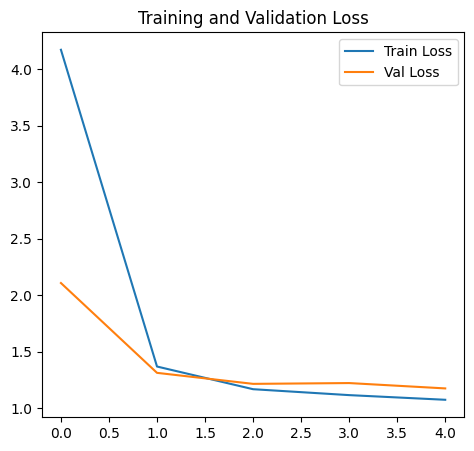

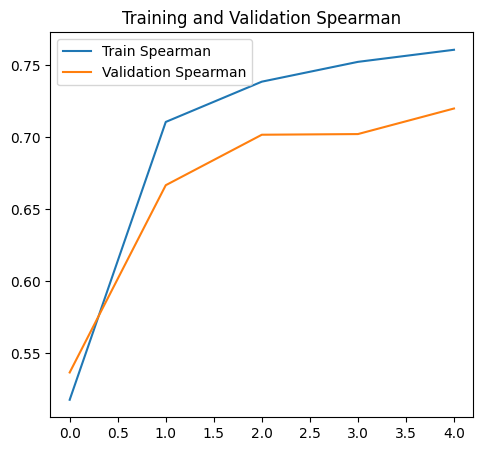

In [10]:
from scipy.stats import spearmanr
# Training loop
best_valloss = 0
train_losses = []
val_losses = []
val_spearman = []
train_spearman = []

for epoch in range(5):
    # Training phase
    model.train()
    running_loss = 0.0
    train_spearman_corr=0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG['num_epochs']} [Train]")
    
    for images, cords, targets in progress_bar:
        images = images.to(CFG['device']) 
        targets = targets.to(CFG['device'])
        cords = cords.to(CFG['device'])
        
        optimizer.zero_grad()
        outputs = model(images, cords)
        loss = combined_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix({'loss': loss.item()})
    
        # Calculate Spearman correlation
        for output,target in zip(outputs.cpu().detach(),targets.cpu().detach()):
            corr, _ = spearmanr(output, target)

            train_spearman_corr += corr
            
    train_spearman_corr = train_spearman_corr / len(train_dataset)
    
    train_spearman.append(train_spearman_corr)
    
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_spearman_corr = 0.0
    with torch.no_grad():
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{CFG['num_epochs']} [Val]")
        for images, cords, targets in val_progress:
            images = images.to(CFG['device']) 
            targets = targets.to(CFG['device'])
            cords = cords.to(CFG['device'])
            
            outputs = model(images, cords)
            loss = combined_loss(outputs, targets)
            val_running_loss += loss.item() * images.size(0)
            
            
            # Calculate Spearman correlation
            for output,target in zip(outputs.cpu().detach(),targets.cpu().detach()):
                corr, _ = spearmanr(output, target)
                val_spearman_corr += corr 

            
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_spearman = val_spearman_corr / len(val_dataset)
    
    val_losses.append(val_epoch_loss)
    val_spearman.append(val_epoch_spearman)
    
    
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")
    print(f"train Spearman: {train_spearman_corr:.4f}")
    print(f"Val Spearman: {val_epoch_spearman:.4f}")
    print("------------------------------------------------")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_spearman, label='Train Spearman')
plt.plot(val_spearman, label='Validation Spearman')
plt.title('Training and Validation Spearman')
plt.legend()



In [12]:
torch.save(model.state_dict(), 'last_model.pth')

In [13]:
#tta prediction

def predict_test_set_with_tta(path):
    model.load_state_dict(torch.load(path))
    model.eval()
    
    # Load test data
    with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", 'r') as f:
        test_spots = pd.DataFrame(f['spots/Test/S_7'][:])
        
    #stain normalized test image
    test_img=norm_images['S_7']
    
    # TTA transformations (add more as needed)
    tta_transforms = [
        lambda x: x,  # Original
        lambda x: x.flip(-1),  # Horizontal flip
        lambda x: x.flip(-2),  # Vertical flip
        lambda x: x.flip(-1).flip(-2),  # Both flips
    ]

    class TestDataset(Dataset):
        def __init__(self, test_spots, test_img, transform_fn):

            self.transform_fn = transform_fn
            self.img = test_img
            self.slide_metadata = {
                'S_7': {
                    'height': test_img.shape[0],
                    'width': test_img.shape[1]
                }
            }
            self.spots = []
            
            # If test_spots is a DataFrame, iterate using iterrows()
            for _, spot in test_spots.iterrows():
                x = spot['x']
                y = spot['y']
                # Append a tuple containing the slide id and coordinates
                self.spots.append(('S_7', x, y))
    
        def __len__(self):
            return len(self.spots)
        
        def __getitem__(self, idx):
            slide_id, x, y = self.spots[idx]
            img = self.img
            meta = self.slide_metadata[slide_id]
            
            # Extract patch with reflection padding
            half = CFG['img_size'] // 2
            y_min = max(0, y - half)
            y_max = min(img.shape[0], y + half)
            x_min = max(0, x - half)
            x_max = min(img.shape[1], x + half)
            
            patch = img[y_min:y_max, x_min:x_max]
            
            # Calculate required padding
            pad_top = half - (y - y_min)
            pad_bottom = (y + half) - y_max
            pad_left = half - (x - x_min)
            pad_right = (x + half) - x_max
            
            patch = np.pad(
                patch,
                ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                mode='reflect'
            )
            
            # Normalize coordinates
            norm_x = x / meta['width']
            norm_y = y / meta['height']
            
            if self.transform_fn:
                patch = self.transform_fn(patch)
            
            return patch, torch.tensor([norm_x, norm_y], dtype=torch.float32)



    # Create dataset and dataloader
    test_dataset = TestDataset(test_spots, test_img, val_transform)
    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Predict with TTA
    predictions = []
    with torch.no_grad():
        for batch_patches, batch_cords in tqdm(test_loader, desc="Processing TTA"):
            batch_patches = batch_patches.to(CFG['device']) 
            batch_cords = batch_cords.to(CFG['device'])
            
            tta_outputs = []
            for tta_fn in tta_transforms:
                # Apply augmentation to all patch sizes
                augmented_patches = tta_fn(batch_patches) 
                
                # Forward pass
                outputs = model(augmented_patches, batch_cords)
                tta_outputs.append(outputs)
            
            # Average predictions across all TTA versions
            avg_pred = torch.mean(torch.stack(tta_outputs), dim=0)
            predictions.append(avg_pred.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    
    # Create submission DataFrame (same as before)
    submission_df = pd.DataFrame(
        predictions,
        columns=[f"C{i+1}" for i in range(CFG['num_cell_types'])]
    )
    submission_df.insert(0, "ID", test_spots.index)
    
    torch.cuda.empty_cache()
    return submission_df

In [15]:
tta_predictions = predict_test_set_with_tta(f"last_model.pth")

Processing TTA: 100%|██████████| 131/131 [01:55<00:00,  1.13it/s]


In [16]:
tta_predictions.head(5)

,ID,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,0,-3.583261,-2.677071,-3.361543,-7.484033,-4.309357,-8.382255,-4.455570,-6.499187,-6.842699,...,-5.070872,-8.495897,-7.303262,-6.596025,-5.122320,-3.173855,-3.478244,-5.870416,-6.596383,-4.359639
1,1,-4.111293,-2.273503,-3.615517,-8.121643,-2.888158,-8.209373,-3.846807,-5.780159,-6.818658,...,-4.909315,-7.849167,-6.716648,-5.322382,-4.481952,-2.827365,-3.231910,-5.096808,-6.437083,-3.992976
2,2,-3.941922,-2.509079,-3.797133,-7.920647,-2.406724,-8.489704,-4.331185,-6.589211,-7.119162,...,-5.829804,-8.143079,-7.363646,-6.039973,-5.668619,-3.086150,-3.592559,-6.014942,-7.086246,-4.472752
3,3,-4.230479,-2.396710,-4.136533,-8.568525,-2.858289,-8.870213,-4.358322,-6.529775,-7.276689,...,-5.730121,-8.474979,-7.385817,-5.749350,-5.079993,-3.093831,-3.524179,-5.983323,-7.189344,-4.425044
4,4,-4.628860,-2.560626,-3.961833,-9.660070,-3.655532,-9.371470,-4.017561,-5.875738,-7.791660,...,-4.695581,-8.533094,-6.903562,-5.515184,-3.942610,-2.791145,-3.422105,-4.971904,-6.916488,-4.266667


In [17]:
from scipy.ndimage import gaussian_filter
#post prediction
def spatial_smoothing(predictions, coordinates, sigma=3.0):
    """Apply Gaussian smoothing to predictions based on spatial coordinates"""
    
    # Convert coordinates to grid indices
    x_coords = coordinates[:,0]
    y_coords = coordinates[:,1]
    
    # Create grid dimensions
    x_min, x_max = x_coords.min(), x_coords.max()
    y_min, y_max = y_coords.min(), y_coords.max()
    
    # Create empty grid
    grid_size = 100  # Adjust based on your spot density
    smoothed_preds = np.zeros_like(predictions)
    
    for cell_type in range(predictions.shape[1]):
        # Create density grid for this cell type
        density_grid = np.zeros((grid_size, grid_size))
        
        # Bin coordinates into grid
        x_bins = np.linspace(x_min, x_max, grid_size)
        y_bins = np.linspace(y_min, y_max, grid_size)
        
        # Rasterize predictions onto grid
        for x, y, val in zip(x_coords, y_coords, predictions[:, cell_type]):
            i = np.digitize(x, x_bins) - 1
            j = np.digitize(y, y_bins) - 1
            density_grid[j,i] += val  # Note: j comes first in grid coordinates
            
        # Apply Gaussian smoothing
        smoothed_grid = gaussian_filter(density_grid, sigma=sigma)
        
        # Map back to original coordinates
        for idx, (x, y) in enumerate(zip(x_coords, y_coords)):
            i = np.digitize(x, x_bins) - 1
            j = np.digitize(y, y_bins) - 1
            smoothed_preds[idx, cell_type] = smoothed_grid[j,i]
            
    return smoothed_preds

In [ ]:
tta_predictions=tta_predictions.drop('ID',axis=1)
raw_preds = tta_predictions.to_numpy()

# Load test spots
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", 'r') as f:
    test_spots = pd.DataFrame(f['spots/Test/S_7'][:])

coordinates = test_spots[['x', 'y']].values

smothed_pred=spatial_smoothing(raw_preds, coordinates)

submission_df = pd.DataFrame(
        smothed_pred,
        columns=[f"C{i+1}" for i in range(CFG['num_cell_types'])]
    )
submission_df.insert(0, "ID", test_spots.index)


In [20]:
submission_df.head(5)

,ID,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,0,-1.029197,-0.714838,-0.968428,-2.209158,-1.305835,-2.361998,-1.226985,-1.737115,-1.902418,...,-1.361562,-2.358415,-1.956362,-1.778680,-1.240265,-0.861033,-0.956963,-1.575722,-1.817362,-1.196000
1,1,-1.087931,-0.655765,-0.995787,-2.269990,-0.949981,-2.312675,-1.098461,-1.608088,-1.912750,...,-1.348993,-2.220782,-1.856474,-1.539661,-1.214869,-0.774646,-0.918551,-1.440485,-1.803158,-1.133744
2,2,-1.127029,-0.747437,-1.094231,-2.279691,-0.797734,-2.404946,-1.287226,-1.947119,-1.989788,...,-1.702986,-2.296057,-2.137881,-1.750904,-1.708523,-0.913872,-1.040231,-1.777547,-2.053814,-1.310943
3,3,-1.197540,-0.764244,-1.184299,-2.508783,-1.070447,-2.724790,-1.376623,-2.057958,-2.241024,...,-1.734102,-2.659491,-2.286060,-1.912486,-1.632207,-0.980271,-1.096667,-1.869245,-2.158163,-1.351189
4,4,-1.310041,-0.709920,-1.126892,-2.727890,-1.030674,-2.651773,-1.155313,-1.669561,-2.203993,...,-1.355428,-2.419495,-1.960920,-1.561971,-1.133341,-0.790751,-0.960745,-1.418329,-1.979290,-1.212003


In [21]:
submission_df.to_csv('submission.csv', index=False)